# Transitions NREM-REM

In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler

In [2]:
import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams['svg.fonttype'] = 'none'
# %matplotlib qt

In [3]:
def transition(states, template,epsilon = 0):
    '''
    states : dict of nts.Interval_set
    template : list of state.
    epsilon : int, will drop any transition in which there is an epoch shorter than epsilon 's'
    This function will find transition that match the template 
    '''
    
    long = pd.DataFrame()
    states = states.copy()
    for s,i in states.items():
        i['state'] = s
        long = pd.concat((i,long))
        del i['state']
    order = np.argsort(long.start)
    long = long.iloc[order]
    
    transition_times = []
    transition_intervals = []
    for i,s in enumerate(long.state):
        tmp = list(long.state[i:i+len(template)])
        if tmp == template:
            tmp_transition = long.iloc[i:i+len(template)]
#             print(d.iloc[i:i+len(template)])
            length = (tmp_transition.end - tmp_transition.start)/1_000_000
            if np.any(length.values<epsilon): 
                continue
            tmp_pre = np.array(tmp_transition.end[:-1])
            tmp_post = np.array(tmp_transition.start[1:])
            tmp_times = np.mean([tmp_pre,tmp_post],0)
            
            
            transition_intervals.append([tmp_transition.start.iloc[0],tmp_transition.end.iloc[-1]])
            transition_times.append(tmp_times)
    
    transition_times = np.array(transition_times)
    transition_intervals = np.array(transition_intervals)
    transition_intervals = nts.IntervalSet(start = transition_intervals[:,0],end = transition_intervals[:,1],force_no_fix = True)
    return transition_intervals,transition_times

## Two states transitions

In [4]:
# transition_interest = [('Rem','sws'),('sws','Rem'),('Rem','wake')]
# s = "ABC"
# fig,ax = plt.subplot_mosaic('ABC')
# for ii,i in enumerate(transition_interest):
#     binned = []
#     for event,trans_time in zip(transitions[i].as_units('s').iloc,times[i].as_units('s').index.values):
#         print(trans_time)
#         print('he')
#         start = event.start
#         end = event.end
        
#         if (end-trans_time)<50 or (trans_time-start) <50: continue
# #         if (end-trans_time) > 180: end = trans_time+120
# #         if (trans_time-start) > 180: start = trans_time-120
        
        
        
#         t_pre,b_pre = bk.compute.binSpikes(neurons,start = start,stop = trans_time,nbins=30)
#         t_post,b_post = bk.compute.binSpikes(neurons,start = trans_time,stop = end,nbins=12)
#         b_pre = b_pre/((trans_time-start)/30)
#         b_post = b_post/((end-trans_time)/12)
#         t = np.hstack((t_pre,t_post))
#         b = np.hstack((b_pre,b_post))
        
# #         plt.figure()
# #         plt.plot(t,b.T)
# #         plt.axvline(trans_time,color = 'red')
#         binned.append(b)
#     ax[s[ii]].plot(np.mean(binned,0).T)
    
# plt.suptitle('Transition')

In [7]:
def main(local_path,plot = True, save = False):
    bk.load.current_session_linux(local_path = local_path)
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()
    
    # Check transitions : 
#     plt.figure()
#     bk.plot.intervals(states['Rem'])
#     bk.plot.intervals(states['sws'],'grey')
    transition_interest = [['sws','Rem','sws']] #Template of transitions to follow.
#     bin_epochs = [12,30,12] # Number of bin per epoch state 
    bin_epochs = [30,12,30]
    for i,transition_name in enumerate(transition_interest): #For each kind of transitions
        print(transition_name)
        intervals,timing = transition(states,transition_name,epsilon=50) #Find the timing of the transitions

        transition_activity = []
        for event,t in zip(intervals.iloc,timing): #For each transitions
            epochs = np.array([[event.start,t[0]],[t[0],t[1]],[t[1],event.end]])
#             epochs = np.array([(event.start,t[0]),(t[0],event.end)],dtype = np.int64)
            epochs = nts.IntervalSet(start = epochs[:,0],end = epochs[:,1])
            #Creates intervals for each state of the transitions events.


    #         binned = np.array(shape = (252,np.sum(bin_epochs)))
    #         binned = np.empty(shape = (252,np.sum(bin_epochs),len(intervals)+1))
            binned = np.empty(shape = (len(neurons),1))
            for i,epoch in enumerate(epochs.as_units('s').iloc):
                start = epoch.start
                end = epoch.end
                nbins = bin_epochs[i]
                _,b = bk.compute.binSpikes(neurons,start = start,stop = end,nbins=nbins)
                b = b/((end-start)/nbins) # Converting to firing rates

                binned = np.hstack((binned,b))
            binned = binned[:,1:]
            transition_activity.append(binned)
        
        transition_activity = np.array(transition_activity)
        transition_activity = np.moveaxis(transition_activity,0,2)
        if plot:
            plt.figure()
            plt.plot(np.mean(transition_activity,2).T)
            plt.axvspan(30,41,color = 'orange',alpha = 0.3)
            plt.title(f'Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}')
        
        
        return np.array(transition_activity),metadata
    #     plt.axvspan(43,71,color = 'orange',alpha = 0.3)
    #         t_pre,b_pre = bk.compute.binSpikes(neurons,start = start,stop = trans_time,nbins=30)
    #         t_in,b_in = bk.compute.binSpikes(neurons,start = trans_time,stop = end,nbins=12)
    #         t_post,b_post = 
    #         b_pre = b_pre/((trans_time-start)/30)
    #         b_post = b_post/((end-trans_time)/12)
    #         t = np.hstack((t_pre,t_post))
    #         b = np.hstack((b_pre,b_post))

    #         plt.figure()
    #         plt.plot(t,b.T)
    #         plt.axvline(trans_time,color = 'red')

100%|██████████| 61/61 [01:18<00:00,  1.29s/it]

Batch finished in 78.95846223831177
Some session were not processed correctly
['Rat08-20130717', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140325', 'Rat09-20140328', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140407', 'Rat10-20140628', 'Rat10-20140702', 'Rat11-20150316', 'Rat11-20150321', 'Rat11-20150323', 'Rat11-20150325', 'Rat11-20150327', 'Rat11-20150328']
26.229508196721312 %


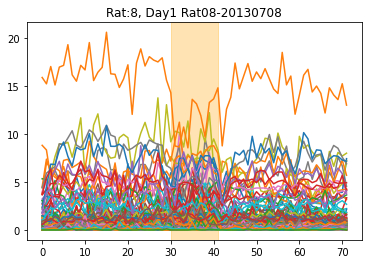

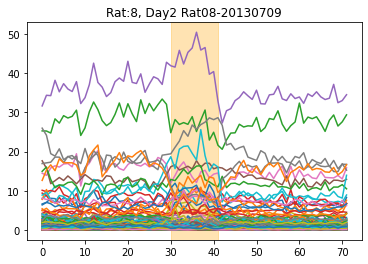

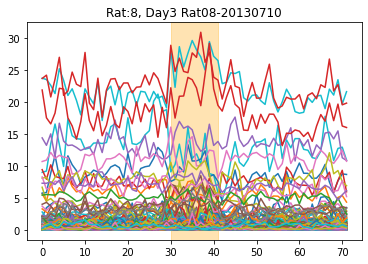

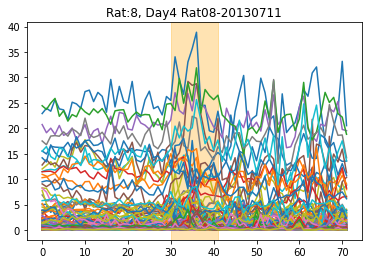

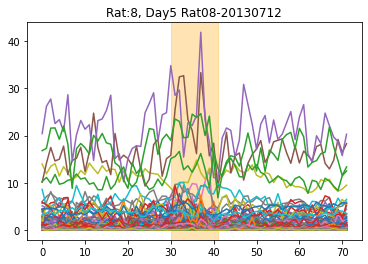

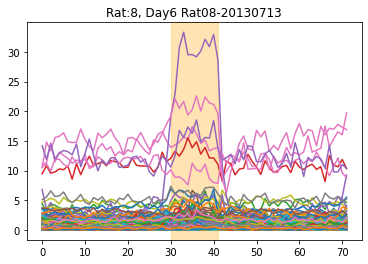

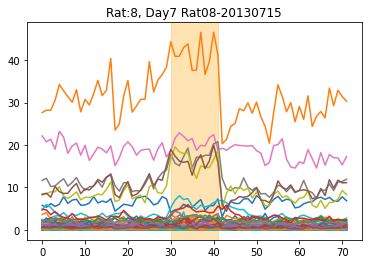

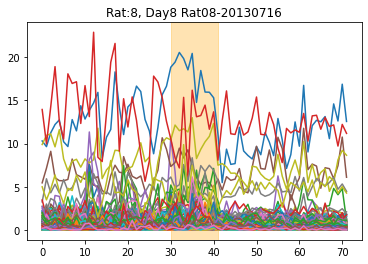

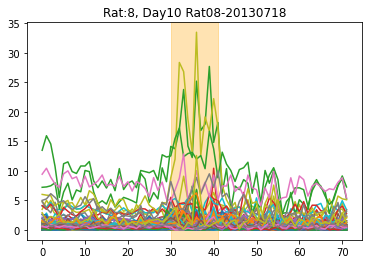

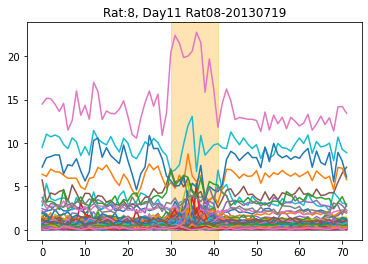

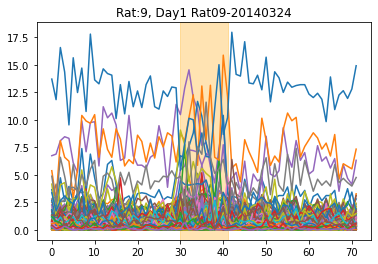

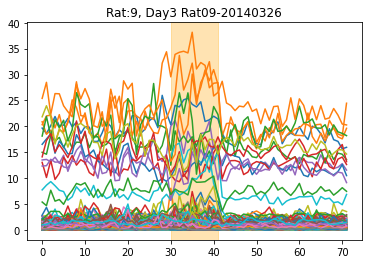

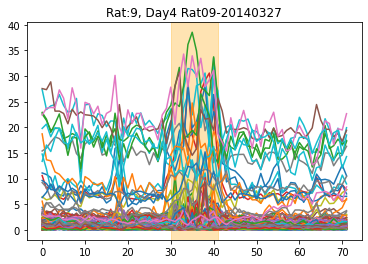

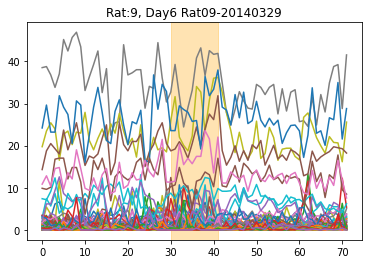

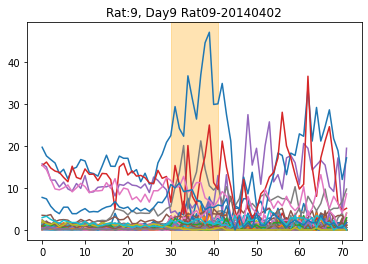

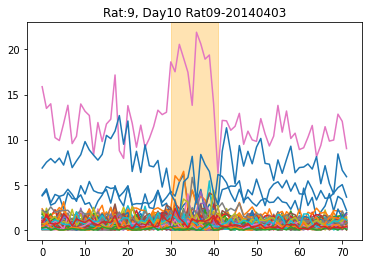

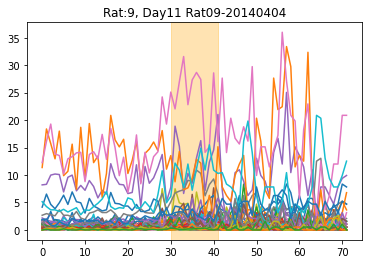

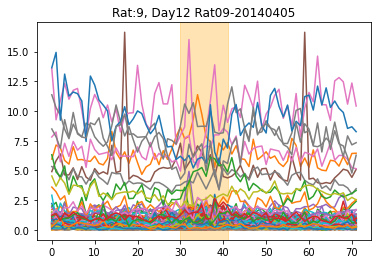

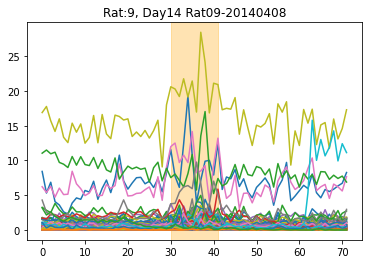

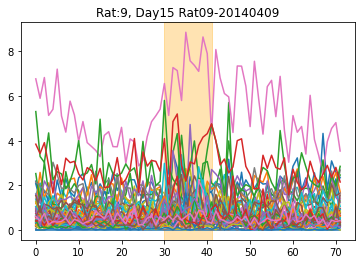

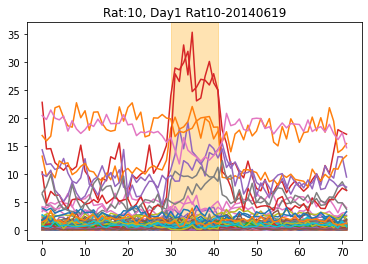

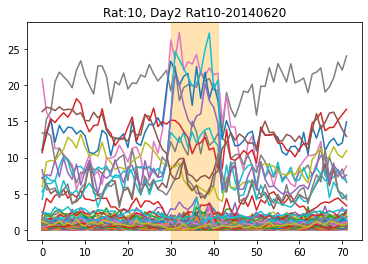

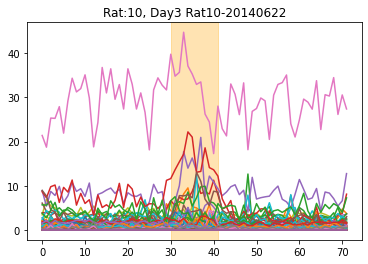

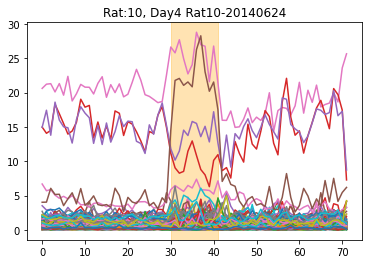

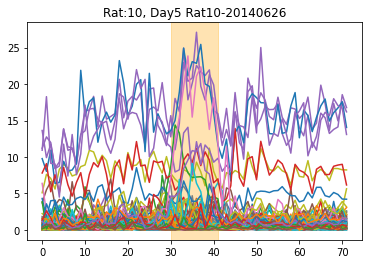

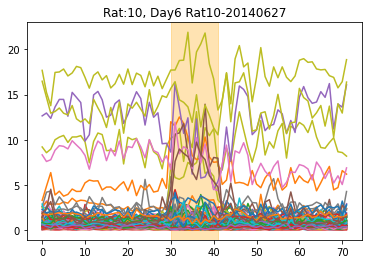

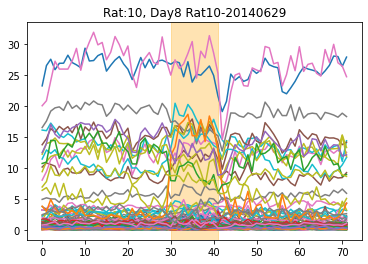

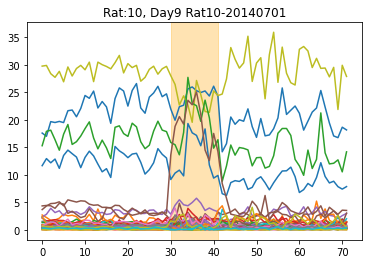

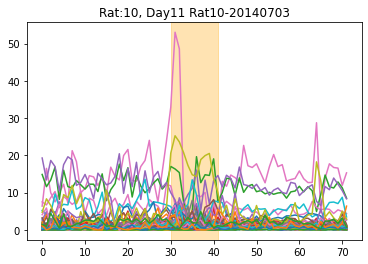

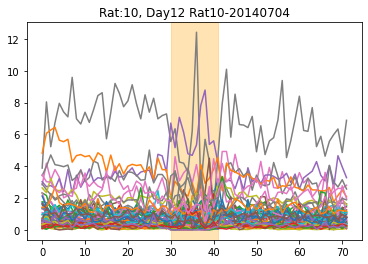

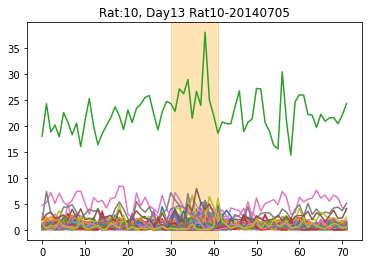

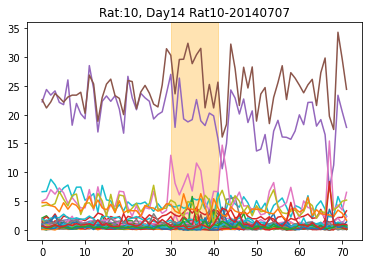

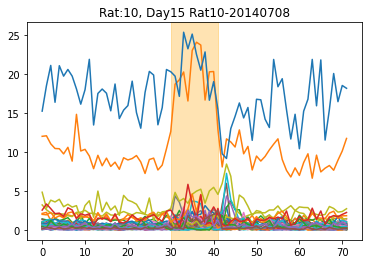

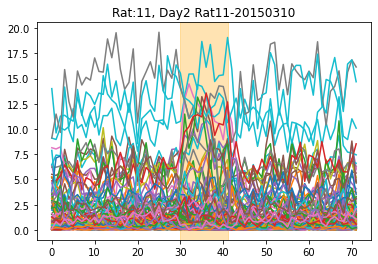

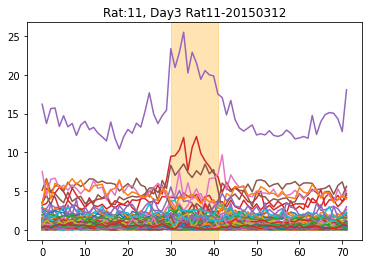

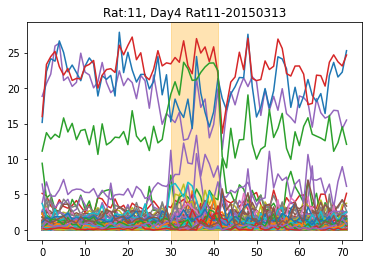

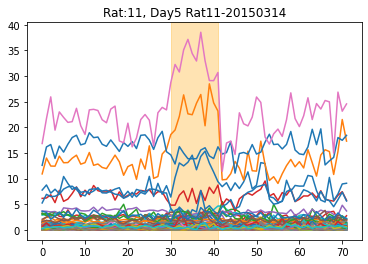

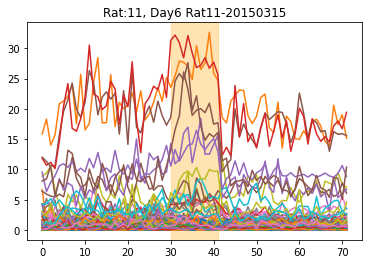

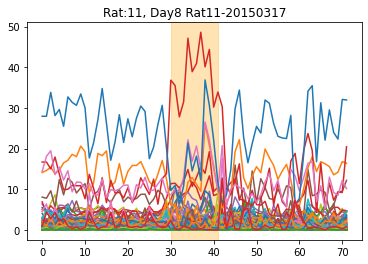

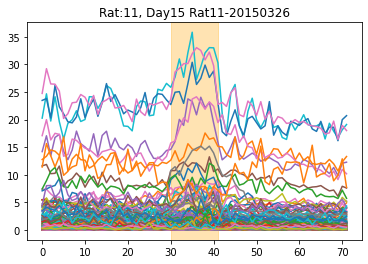

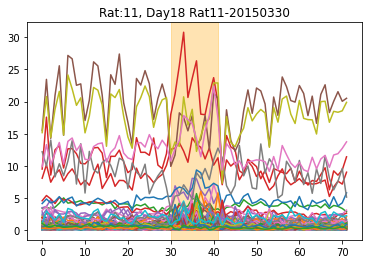

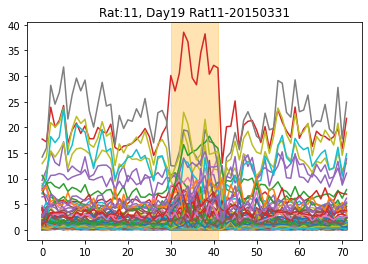

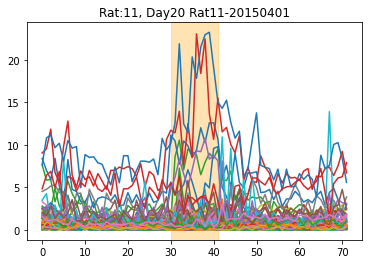

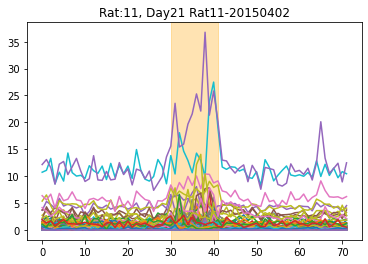

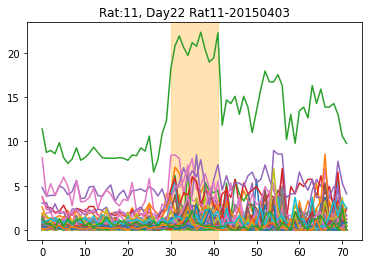

In [8]:
bk.load.current_session_linux()
batch = bk.load.batch(main,verbose=False,linux=True)

## Three states transitions

In [3]:
bk.load.current_session_linux()
neurons,metadata = bk.load.loadSpikeData(bk.load.path)
states = bk.load.states()
# transition,times = bk.compute.transitions_times(states,5)
# first_transition_time = times
# transition,times = bk.compute.transitions_times(transition,5)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [11]:
batch['Rat08-20130708'][0].shape

(166, 72, 3)

In [4]:
%matplotlib qt

In [14]:
fig,ax = plt.subplot_mosaic('''A
                               B''')
ax['A'].get_shared_x_axes().join(ax['A'], ax['B']) 
for i,j in transition.items():
    if (i[0][0] == 'sws') and (i[0][1])== 'Rem' and (i[1][0] == 'sws') : 
        if np.any(j):
            plt.sca(ax['A'])
            bk.plot.intervals(j,'blue')
            print(i)
plt.sca(ax['B'])
bk.plot.intervals(states['Rem'],'orange')
bk.plot.intervals(states['sws'],'grey')

(('sws', 'Rem'), ('sws', 'wake'))
(('sws', 'Rem'), ('sws', 'drowsy'))


In [145]:
inter,t = transition(states,['sws','Rem','sws'])

In [149]:
fig,ax = plt.subplot_mosaic('''
                            A
                            B
                            ''')
ax['A'].get_shared_x_axes().join(ax['A'], ax['B']) 

plt.sca(ax['A'])
bk.plot.intervals(states['Rem'],'orange')
bk.plot.intervals(states['sws'],'grey')
plt.sca(ax['B'])
bk.plot.intervals(inter)

for s in t.ravel():
    ax['B'].axvline(s/1_000_000)
plt.show()

In [59]:
neurons,metadata = bk.load.loadSpikeData(bk.load.path)

Data already saved in Numpy format, loading them from here:
Rat11-20150403-neurons.npy
Rat11-20150403-metadata.npy


In [170]:
for i in range(60):
    print(a['BLA_PYR'][i][0][0][0][1])

[[ 8  1  7  2 40  1]
 [ 8  1  7  3 41  1]
 [ 8  1  7  4 42  1]
 [ 8  1  7  5 43  1]
 [ 8  1  7  6 44  1]
 [ 8  1  7  7 45  1]
 [ 8  1  7  8 46  1]
 [ 8  1  7  9 47  1]
 [ 8  1  7 10 48  1]
 [ 8  1  7 11 49  1]
 [ 8  1  7 12 50  1]
 [ 8  1  7 13 51  1]
 [ 8  1  7 14 52  1]
 [ 8  1  7 15 53  1]
 [ 8  1  7 16 54  1]]
[[  8   2   6   2  48   1]
 [  8   2   6   3  49   1]
 [  8   2   6   4  50   1]
 [  8   2   6   5  51   1]
 [  8   2   6   6  52   1]
 [  8   2   6   7  53   1]
 [  8   2   6  11  57   1]
 [  8   2   7   2  58   1]
 [  8   2   7   3  59   1]
 [  8   2   7   4  60   1]
 [  8   2   7   5  61   1]
 [  8   2   7   6  62   1]
 [  8   2   7   7  63   1]
 [  8   2   7   8  64   1]
 [  8   2   7   9  65   1]
 [  8   2   7  10  66   1]
 [  8   2   7  11  67   1]
 [  8   2   7  12  68   1]
 [  8   2   7  13  69   1]
 [  8   2   7  14  70   1]
 [  8   2   7  15  71   1]
 [  8   2   7  16  72   1]
 [  8   2   7  17  73   1]
 [  8   2   7  18  74   1]
 [  8   2   7  19  75   1]
 [  8   2

IndexError: index 38 is out of bounds for axis 0 with size 38

In [60]:
metadata

Rat Day Shank  Id Region Type
0   11  22     1   2    BMP  Pyr
1   11  22     1   3    BMP  Pyr
2   11  22     3   2    BMP  Pyr
3   11  22     3   3    BMP  Int
4   11  22     3   4    BMP  Pyr
5   11  22     3   5    BMP  Pyr
6   11  22     3   6    BMP  Int
7   11  22     4   2    Pir  Pyr
8   11  22     4   3    Pir  Pyr
9   11  22     4   4    Pir  Pyr
10  11  22     5   2    BLV  Pyr
11  11  22     5   3    BLV  Pyr
12  11  22     5   4    BLV  Pyr
13  11  22     5   5    BLV  Pyr
14  11  22     7   2    Pir  Pyr
15  11  22     7   3    Pir  Pyr
16  11  22     7   4    Pir  Pyr
17  11  22     8   2    Pir  Pyr
18  11  22     8   3    Pir  Pyr
19  11  22     8   4    Pir  Pyr
20  11  22     8   5    Pir  Pyr
21  11  22     8   6    Pir  Pyr
22  11  22     8   7    Pir  Pyr
23  11  22     8   8    Pir  Pyr
24  11  22     8   9    Pir  Pyr
25  11  22     8  10    Pir  Pyr
26  11  22     8  11    Pir  Pyr
27  11  22     8  12    Pir  Pyr
28  11  22     8  13    Pir  Pyr
29  11  22     9   2    Pir  Pyr
30  11  22     9   3    Pir  Pyr
31  11  22     9   4    Pir  Pyr
32  11  22     9   5    Pir  Pyr
33  11  22     9   6    Pir  Pyr
34  11  22     9   7    Pir  Pyr
35  11  22     9   8    Pir  Pyr
36  11  22     9   9    Pir  Pyr
37  11  22     9  10    Pir  Pyr
38  11  22    10   2    Pir  Pyr
39  11  22    12   2    Pir  Pyr
40  11  22    12   3    Pir  Pyr
41  11  22    12   4    Pir  Pyr
42  11  22    12   5    Pir  Pyr
43  11  22    12   6    Pir  Pyr
44  11  22    12   7    Pir  Pyr
45  11  22    12   8    Pir  Pyr
46  11  22    12   9    Pir  Pyr
47  11  22    12  10    Pir  Pyr
48  11  22    12  11    Pir  Pyr
49  11  22    12  12    Pir  Pyr
50  11  22    12  13    Pir  Pyr
51  11  22    12  14    Pir  Pyr
52  11  22    13   2    Pir  Pyr